In [1]:
# Import Data handling/display libraries
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Union, Dict
# Import scikit-learn core slibraries
from sklearn.metrics         import auc, roc_auc_score, roc_curve
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from collections             import Counter
from IPython.display         import Markdown, display
# Import IBM's AI Fairness tooolbox
from aif360.datasets   import BinaryLabelDataset  # To handle the data
from aif360.metrics    import BinaryLabelDatasetMetric, ClassificationMetric, DatasetMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms import Transformer
from aif360.algorithms.preprocessing import DisparateImpactRemover # Preprocessing technique
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Taiwan-Credit-Card-Cleaned-Gender dataset
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-Cleaned-Gender.csv')

In [3]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'GENDER'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'DEFAULT'
fav_label           = 1 # Will not default next month
unfav_label         = 0 # Will default next month
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [4]:
# Create a Binary Label Dataset to use with AIF360 APIs
X = Taiwan_df.drop(lab,axis=1)
y = Taiwan_df[lab]

In [5]:
Taiwan_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [6]:
# Create train and test datasets
Taiwan_train_bld, Taiwan_test_bld = Taiwan_bld.split([0.8], shuffle=True, seed=101)

In [7]:
scaler = MinMaxScaler(copy=False)
Taiwan_train_bld.features = scaler.fit_transform(Taiwan_train_bld.features)
Taiwan_test_bld.features  = scaler.fit_transform(Taiwan_test_bld.features)

In [8]:
Taiwan_train_df, d = Taiwan_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Taiwan_test_df,  d = Taiwan_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [9]:
# First test whether it is possible to predict the Sensitive Variable from the whole original dataset
X_se_train = Taiwan_train_df.drop(protected_attr,axis=1)
y_se_train = Taiwan_train_df[protected_attr]
X_se_test  = Taiwan_test_df.drop(protected_attr,axis=1)
y_se_test  = Taiwan_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.6075
Biased Random Forest       validation accuracy: 0.613

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.5391934491147057
Biased Random Forest       balanced accuracy  : 0.5121004265621344


In [10]:
# Next get the number of labels from the modified training dataset
print('Training Before - DEFAULT value counts:')
print(Taiwan_train_df.DEFAULT.value_counts())
print('Training Before - GENDER value counts:')
print(Taiwan_train_df.GENDER.value_counts())

Training Before - DEFAULT value counts:
1.0    18735
0.0     5265
Name: DEFAULT, dtype: int64
Training Before - GENDER value counts:
0.0    14478
1.0     9522
Name: GENDER, dtype: int64


In [11]:
# Determine the baseline model accuracy for Logistic Regression and Random Forest Classifiers
X_train = Taiwan_train_df.drop(lab,axis=1)
y_train = Taiwan_train_df[lab]
X_test  = Taiwan_test_df.drop(lab,axis=1)
y_test  = Taiwan_test_df[lab]

BiasedLogModel = LogisticRegression(random_state=101)
BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)

BiasedLogModel.fit(X_train, y_train) 
BiasedRfcModel.fit(X_train, y_train)

BiasedLogPredictions = BiasedLogModel.predict(X_test)
BiasedRfcPredictions = BiasedRfcModel.predict(X_test)
print(f"Biased Logistic regression validation accuracy: {BiasedLogModel.score(X_test, y_test)}")
print(f"Biased Random Forest       validation accuracy: {BiasedRfcModel.score(X_test, y_test)}")
print('')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, BiasedLogPredictions)}")
print(f"Biased Random forest balanced accuracy        : {balanced_accuracy_score(y_test, BiasedRfcPredictions)}")

Biased Logistic regression validation accuracy: 0.8083333333333333
Biased Random Forest       validation accuracy: 0.7946666666666666

Biased Logistic regression balanced accuracy  : 0.648105630330714
Biased Random forest balanced accuracy        : 0.5845750295563172


In [12]:
# Create the binary label dataset metric class for the training dataset
metric_train_bld = BinaryLabelDatasetMetric(Taiwan_train_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))
display(Markdown("#### Biased training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

#### Biased training dataset

Number of instances           : 24000.0
Base Rate                     :0.780625
Consistency                   : [0.78445833]
Disparate Impact              : 1.0437451995559814
Mean Difference               : 0.03327060860999975
Statistical Parity Difference : 0.03327060860999975
# of positives(privileged)    : 7242.0
# of positives(non-privileged): 11493.0
Total positive instances"     : 18735.0
# of negatives(privileged)    : 2280.0
# of negatives(non-privileged): 2985.0
Total negative instances"     : 5265.0


#### Biased training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.033271


In [13]:
#Test for equality of odds. 
Test_Log_bld = Taiwan_test_bld.copy(deepcopy=True)
Test_Rfc_bld = Taiwan_test_bld.copy(deepcopy=True)
TestLogPredictions = BiasedLogModel.predict(X_test)
TestRfcPredictions = BiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Taiwan_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Taiwan_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [14]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.04166681223548929
Log average_odds_difference:     0.04166681223548929
 
Rfc average_abs_odds_difference: 0.011766323944724433
Rfc average_odds_difference:     0.011766323944724433


In [15]:
from tqdm import tqdm
index = Taiwan_train_bld.feature_names.index(protected_attr)
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(Taiwan_train_bld)
    test_repd = di.fit_transform(Taiwan_test_bld)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=101)
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    DIs.append(cm.disparate_impact())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:04<00:00, 10.14s/it]


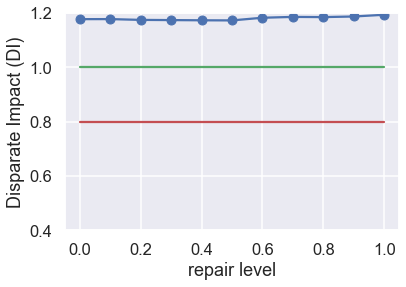

In [16]:
%matplotlib inline
plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

In [17]:
# Where the plot meets the 0.8 (threshold) line is where we target, eg level = 0.1
# Therefore set up an instance of the disparate remover object using this repair level
di = DisparateImpactRemover(repair_level=0.1)
Taiwan_di_train_bld = di.fit_transform(Taiwan_train_bld)
Taiwan_di_test_bld  = di.fit_transform(Taiwan_test_bld)

In [18]:
# Train Logistic and Random Forest classifiers with the transformed dataset.
X_di_train = np.delete(Taiwan_di_train_bld.features,index, axis=1) # Drop Gender! This is what the AIF360 example does
X_di_test  = np.delete(Taiwan_di_test_bld.features, index, axis=1) # thus we cannot compare before and after feature 
y_di_train = Taiwan_di_train_bld.labels.ravel()                    # importance, and binary label dataset metrics because
y_di_test  = Taiwan_di_test_bld.labels.ravel()                     # the sensitive attr has been dropped. Doh!

Di_LogModel= LogisticRegression(class_weight='balanced', solver='liblinear', random_state=101)
Di_RfcModel= RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)

Di_LogModel.fit(X_di_train, y_train)
Di_RfcModel.fit(X_di_train, y_train)

Di_train_LogPredictions= Di_LogModel.predict(X_di_train) 
Di_train_RfcPredictions= Di_RfcModel.predict(X_di_train)
Di_test_LogPredictions = Di_LogModel.predict(X_di_test) 
Di_test_RfcPredictions = Di_RfcModel.predict(X_di_test)

# Now test whether we can predict Gender from the test dataset
print('Model Accuracy after DI removed:')
print(f"Unbiased Logistic regression validation accuracy: {Di_LogModel.score(X_di_test, y_di_test)}")
print(f"Unbiased Random Forest       validation accuracy: {Di_RfcModel.score(X_di_test, y_di_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Unbiased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, Di_test_LogPredictions)}")
print(f"Unbiased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_test, Di_test_RfcPredictions)}")

Model Accuracy after DI removed:
Unbiased Logistic regression validation accuracy: 0.539
Unbiased Random Forest       validation accuracy: 0.7996666666666666

Biased Balanced accuracy
Unbiased Logistic regression balanced accuracy  : 0.6196062970909777
Unbiased Random Forest       balanced accuracy  : 0.6037297921532645


In [19]:
Taiwan_di_test_bld_cpy        = Taiwan_di_test_bld.copy()
Taiwan_di_test_bld_cpy.labels = Di_test_LogPredictions

Taiwan_di_train_bld_cpy       = Taiwan_di_train_bld.copy()
Taiwan_di_train_bld_cpy.labels= Di_train_LogPredictions

metric_train_bld = BinaryLabelDatasetMetric(Taiwan_di_test_bld_cpy, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))
display(Markdown("#### Biased training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

#### Biased training dataset

Number of instances           : 6000.0
Base Rate                     :0.416500
Consistency                   : 0.9187666666666675
Disparate Impact              : 1.1770525560715588
Mean Difference               : 0.06660049657805889
Statistical Parity Difference : 0.06660049657805889
# of positives(privileged)    : 890.0
# of positives(non-privileged): 1609.0
Total positive instances"     : 2499.0
# of negatives(privileged)    : 1476.0
# of negatives(non-privileged): 2025.0
Total negative instances"     : 3501.0


#### Biased training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.066600


In [20]:
Taiwan_di_train_df,d = Taiwan_di_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Taiwan_di_test_df, d = Taiwan_di_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [21]:
# Test for Equality of Odds
Taiwan_Log_di_test_bld        = Taiwan_di_test_bld.copy()
Taiwan_Rfc_di_test_bld        = Taiwan_di_test_bld.copy()

Taiwan_Log_di_test_bld.labels = Di_test_LogPredictions
Taiwan_Rfc_di_test_bld.labels = Di_test_RfcPredictions

c_Log_metric = ClassificationMetric(Taiwan_di_test_bld, Taiwan_Log_di_test_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Taiwan_di_test_bld, Taiwan_Rfc_di_test_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [22]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.05491788239345523
Log average_odds_difference:     0.05491788239345523
 
Rfc average_abs_odds_difference: 0.006092278225835801
Rfc average_odds_difference:     0.006092278225835801


In [23]:
# Let's take a look at the differences between the original dataset and the DI_removed dataset
Taiwan_train_df   = Taiwan_train_df.reset_index(drop=True)
Taiwan_di_train_df= Taiwan_di_train_df.reset_index(drop=True)
TaiwanBool        = (Taiwan_train_df != Taiwan_di_train_df).stack()  # Create Frame of comparison booleans
Taiwandiff        = pd.concat([Taiwan_train_df.stack()[TaiwanBool], Taiwan_di_train_df.stack()[TaiwanBool]], axis=1)
Taiwandiff.columns=["Taiwan_train_df", "Taiwan_di_train_df"]
print(Taiwandiff)

                 Taiwan_train_df  Taiwan_di_train_df
0     BILL_AMT1         0.181479            0.181478
      BILL_AMT3         0.184931            0.184928
      BILL_AMT4         0.193873            0.193868
      BILL_AMT5         0.089884            0.089882
      BILL_AMT6         0.373913            0.373906
1     BILL_AMT1         0.243297            0.243214
      BILL_AMT2         0.156734            0.156574
      BILL_AMT3         0.254543            0.254439
      BILL_AMT4         0.229724            0.229541
      BILL_AMT5         0.125373            0.125233
      BILL_AMT6         0.410898            0.410709
      PAY_AMT1          0.002633            0.002609
      PAY_AMT2          0.002119            0.002099
      PAY_AMT3          0.001800            0.001775
      PAY_AMT4          0.001932            0.001905
      PAY_AMT5          0.004689            0.004626
      PAY_AMT6          0.002459            0.002427
2     BILL_AMT1         0.231457            0.

Accuracy:


,LogReg,RFC
Biased,0.808333,0.794667
Fair,0.539000,0.799667


AUC:


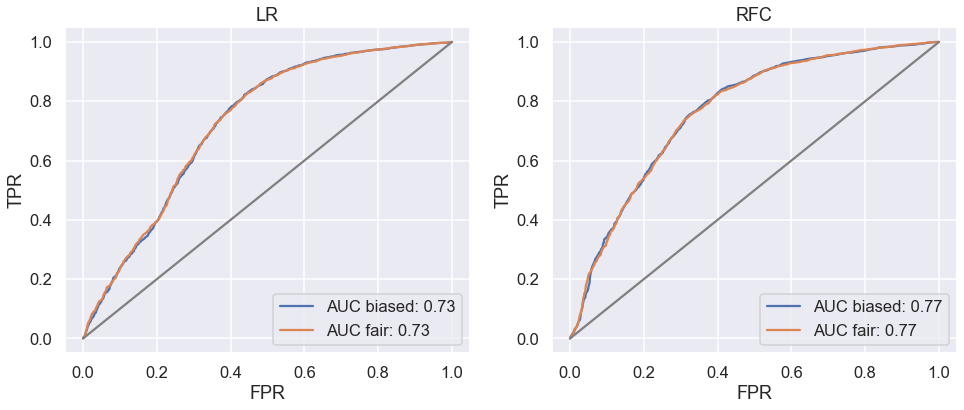

In [24]:
%matplotlib inline
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray], title: str='', ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, y=tpr, ci=None, ax=ax)
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray',ax=ax)
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [BiasedLogModel.score(X_test, y_test), 
                                 Di_LogModel.score(X_di_test, y_di_test)],
                      'RFC': [BiasedRfcModel.score(X_test, y_test),
                              Di_RfcModel.score(X_di_test, y_di_test)]}, 
                      index =['Biased', 'Fair']))

print('AUC:')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
plot_auc(y_test, 
         {'AUC biased': BiasedLogModel.predict_proba(X_test)[:, 1], 
          'AUC fair'  : Di_LogModel.predict_proba(X_di_test)[:, 1]},
         title='LR', ax=ax[0]) 
plot_auc(y_test, 
         {'AUC biased': BiasedRfcModel.predict_proba(X_test)[:, 1],
          'AUC fair'  : Di_RfcModel.predict_proba(X_di_test)[:, 1]},
         title='RFC', ax=ax[1]) 
plt.show()

In [25]:
# Finally test whether it is possible to predict the Sensitive Variable from the transformed dataset
X_se_train = Taiwan_di_train_df.drop(protected_attr,axis=1)
y_se_train = Taiwan_di_train_df[protected_attr]
X_se_test  = Taiwan_di_test_df.drop(protected_attr,axis=1)
y_se_test  = Taiwan_di_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.6073333333333333
Biased Random Forest       validation accuracy: 0.606

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.5390558596815741
Biased Random Forest       balanced accuracy  : 0.5004226542688082


In [26]:
# Lastly get the number of labels from the modified training dataset
print('Training After - DEFAULT value counts:')
print(Taiwan_di_train_df.DEFAULT.value_counts())
print('Training After - GENDER value counts:')
print(Taiwan_di_train_df.GENDER.value_counts())

Training After - DEFAULT value counts:
1.0    18735
0.0     5265
Name: DEFAULT, dtype: int64
Training After - GENDER value counts:
0.0    14478
1.0     9522
Name: GENDER, dtype: int64
